reference:
https://blog.amedama.jp/entry/hyperopt

In [1]:
# basic
import numpy as np
import pandas as pd

# plot
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import pprint

# model
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR

# optimization
from functools import partial
from sklearn.model_selection import KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as MSE

# importance
import eli5
from eli5.sklearn import PermutationImportance

# other
import pickle
import time
import datetime

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_pickle('../features/feature_train_2020-11-07-08-04-37_treated.pkl')
test = pd.read_pickle('../features/feature_test_2020-11-07-08-04-37_treated.pkl')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_X = train.drop(['id', 'mpg'], axis=1)
train_y = train['mpg']

In [3]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(X, y, args):
    model = SVR(**args)
    
    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    
    score_func = {
        'score':make_scorer(RMSE)
    }
    
    cv_result = cross_validate(model, X=X, y=y, cv=kf, return_estimator=True, scoring=score_func)
    #models.append(cv_result['estimator'])
    
    return {
        'loss':cv_result['test_score'].mean(),
        'status':STATUS_OK,
        'params':args
    }

In [25]:
#models = []

f = partial(objective, train_X, train_y)

param_space = {
    'kernel': 'rbf',
    'C': hp.loguniform(
        label='C', low=np.log(1e-8), high=np.log(10)
    ),
    'gamma': hp.loguniform(
        label='gamma', low=np.log(1e-8), high=np.log(10)
    ),
    'epsilon':hp.loguniform(
        label='epsilon', low=np.log(1e-8), high=np.log(10)
    )
}

trials=Trials()

best = fmin(
    fn=f,
    space=param_space, 
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

pprint.pprint(space_eval(param_space, best))

100%|███████████████████████████████████████████████| 100/100 [00:04<00:00, 21.23trial/s, best loss: 4.805701649449387]
{'C': 9.943643156757906,
 'epsilon': 8.602984068278596e-06,
 'gamma': 0.00020330170101844823,
 'kernel': 'rbf'}


In [29]:
result = [(i['loss'], i['params']) for i in trials.results]
result.sort()
pprint.pprint(result[:5])

[(4.805701649449387,
  {'C': 9.943643156757906,
   'epsilon': 8.602984068278596e-06,
   'gamma': 0.00020330170101844823,
   'kernel': 'rbf'}),
 (4.819190167693782,
  {'C': 9.34974983181217,
   'epsilon': 4.578981870553606e-05,
   'gamma': 0.00010178740289341441,
   'kernel': 'rbf'}),
 (4.829133848529684,
  {'C': 6.396433932812694,
   'epsilon': 1.0257916855402674e-05,
   'gamma': 0.00022694861815045512,
   'kernel': 'rbf'}),
 (4.830618023618165,
  {'C': 6.848223474627872,
   'epsilon': 1.7938268111034195e-05,
   'gamma': 0.0002511596567966114,
   'kernel': 'rbf'}),
 (4.912351963902501,
  {'C': 5.079947893497635,
   'epsilon': 8.373561177916827e-07,
   'gamma': 7.555862275228404e-05,
   'kernel': 'rbf'})]


In [23]:
param_C = [result['params']['C'] for result in trials.results]
param_gamma = [result['params']['gamma'] for result in trials.results]
param_epsilon = [result['params']['epsilon'] for result in trials.results]
scores = np.array([result['loss'] for result in trials.results])

findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


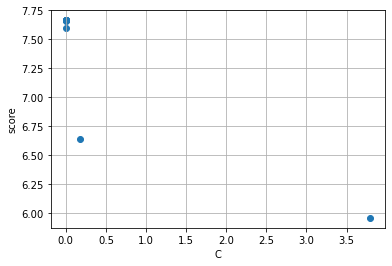

In [24]:
plt.scatter(param_C, scores)
plt.xlabel('C')
plt.ylabel('score')
plt.grid()
plt.show()

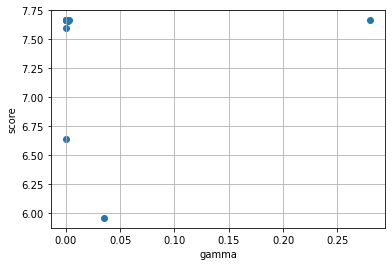

In [25]:
plt.scatter(param_gamma, scores)
plt.xlabel('gamma')
plt.ylabel('score')
plt.grid()
plt.show()

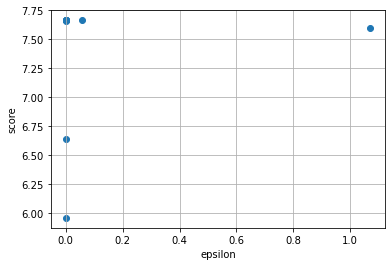

In [26]:
plt.scatter(param_epsilon, scores)
plt.xlabel('epsilon')
plt.ylabel('score')
plt.grid()
plt.show()